In [ ]:
! git clone https://github.com/akshaymurali01/3D-Shape-Completion-For-Autonomous-Vehicles

Cloning into '3D-Shape-Completion-For-Autonomous-Vehicles'...
remote: Enumerating objects: 484, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 484 (delta 11), reused 75 (delta 11), pack-reused 409
Receiving objects: 100% (484/484), 156.45 MiB | 36.77 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as pyplt
import matplotlib.image as mpimg
import cv2
from glob import glob
from albumentations import HorizontalFlip, VerticalFlip, OpticalDistortion, ElasticTransform,GridDistortion

def pathloader(address):
    x = sorted(glob(os.path.join(address, 'new_train','*.png')))
    y = sorted(glob(os.path.join(address, 'new_train_mask', '*.png')))
    return x, y

"""
def augment(image, mask, savepath,augment = True):
    H = 512
    W = 512

    for (x, y) in zip(image, mask):
      name = x.split('/')[-1].split('.')[0]

      x = cv2.imread(x, cv2.IMREAD_COLOR)
      y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
      aug = HorizontalFlip(p=1.0)
      augmented = aug(image=x, mask=y)
      x1 = augmented['image']
      y1 = augmented['mask']

      aug = VerticalFlip(p=1.0)
      augmented = aug(image=x, mask=y)
      x2 = augmented['image']
      y2 = augmented['mask'] 

      aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
      augmented = aug(image=x, mask=y)
      x3 = augmented['image']
      y3 = augmented['mask']

      aug = GridDistortion(p=1)
      augmented = aug(image=x, mask=y)
      x4 = augmented['image']
      y4 = augmented['mask']

      aug = OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
      augmented = aug(image=x, mask=y)
      x5 = augmented['image']
      y5 = augmented['mask']

      X = [x, x1, x2, x3, x4, x5]
      Y = [y, y1, y2, y3, y4, y5]

      index = 1

      for i, j in zip(X, Y):
         i = cv2.resize(i, (W, H))
         j = cv2.resize(j, (W, H))

         image_name = f"{name}_{index}.png"
         image_mask_name = f"{name}_{index}.png"

         image_name_location = os.path.join(savepath, 'new_train', image_name)
         image_mask_name_location = os.path.join(savepath, 'new_train_mask', image_mask_name)

         cv2.imwrite(image_name_location, i)
         cv2.imwrite(image_mask_name_location, j)

         index += 1



create_dir(os.path.join('data_semantics',"new_train"))
create_dir(os.path.join('data_semantics',"new_train_mask"))
X,Y = pathloader('data_semantics')
print("going to augment")
augment(X,Y,'data_semantics')
print("done")

"""



def iou(y_true,y_prev):
    def f(y_true,y_pred):
        intersection = (y_true*y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = intersection/union
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f,[y_true,y_prev],tf.float32)

def dice_coef(y_true,y_pred):
    y_true = keras.layers.Flatten()(y_true)
    y_pred = keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true*y_pred)
    dice_coeff = (2*intersection)/(tf.reduce_sum(y_true)+tf.reduce_sum(y_pred))
    return  dice_coeff

def dice_loss(y_true,y_pred):
    return 1.0-dice_coef(y_true,y_pred)

def down_block(x,filters,filter_size = (3,3),stride = 1,padding = 'same'):

  c = keras.layers.Conv2D(filters,filter_size,strides=stride,padding=padding,activation='relu')(x)
  c = keras.layers.Conv2D(filters,filter_size,strides=stride,padding=padding,activation='relu')(c)
  p = keras.layers.MaxPool2D((2,2),(2,2))(c)
  return c,p

def up_block(x,skip_layer,filters,filter_size = (3,3),stride = 1,padding = 'same'):

  up_sample = keras.layers.UpSampling2D((2,2))(x)
  concatnt = keras.layers.Concatenate()([up_sample,skip_layer])
  c = keras.layers.Conv2D(filters,filter_size,strides=stride,padding=padding,activation='relu')(concatnt)
  c = keras.layers.Conv2D(filters,filter_size,strides=stride,padding=padding,activation='relu')(c)
  return c


def bottleneck(x,filters,filter_size = (3,3),stride = 1,padding = 'same'):
  c = keras.layers.Conv2D(filters,filter_size,strides=stride,padding=padding,activation='relu')(x)
  c = keras.layers.Conv2D(filters,filter_size,strides=stride,padding=padding,activation='relu')(c)
  return c

def UNet():
  inputs = keras.layers.Input((512,512,3))

  p0 = inputs
  print(p0.shape)
  c1,p1 = down_block(p0,64)
  print(p1.shape)
  c2,p2 = down_block(p1,128)
  print(p2.shape)
  c3,p3 = down_block(p2,256)#16
  print(p3.shape)
  c4,p4 = down_block(p3,512)#8
  print(p4.shape)

  c6 = bottleneck(p4,1024)

  c7 = up_block(c6,c4,512)
  print(c7.shape)
  c8 = up_block(c7,c3,256)
  print(c8.shape)
  c9 = up_block(c8,c2,128)
  print(c9.shape)
  c10 = up_block(c9,c1,64)
  print(c10.shape)

  outputs = keras.layers.Conv2D(1,(1,1),(1,1),padding='same',activation = 'sigmoid')(c10)
  print(outputs.shape)

  model = keras.models.Model(inputs,outputs,name="UNet")
  return model

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision



(H,W) = (512,512)
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def pathloader(address):
    x = sorted(glob(os.path.join(address, 'new_train','*.png')))
    y = sorted(glob(os.path.join(address, 'new_train_mask', '*.png')))
    return x, y
def pathloadervalid(address):
    x = sorted(glob(os.path.join(address, 'valid','*.png')))
    y = sorted(glob(os.path.join(address, 'valid_mask', '*.png')))
    return x, y

def shuffling(x,y):
    x,y = shuffle(x,y,random_state=31)
    return x,y

def read_image(path):
    path = path.decode()
    image = cv2.imread(path,cv2.IMREAD_COLOR)
    image = cv2.resize(image,(512,512))
    image = image/255
    image = image.astype(np.float32)
    return image

def read_mask(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image,(512,512))
    for i in range(len(image[:,0])):
        for j in range(len(image[0,:])):
            if(image[i,j]==26):
                image[i,j] = 1
            else:
                image[i,j]=0
    image = image.astype(np.float32)
    image = np.expand_dims(image,axis = -1)
    return image

def tf_read(x,y):
    def f(x,y):
        x = read_image(x)
        y = read_mask(y)
        return x,y
    x,y = tf.numpy_function(f,[x,y],[tf.float32,tf.float32])
    x.set_shape([H,W,3])
    y.set_shape([H, W, 1])
    return x,y

def tf_dataset(X,Y,batchsize):
    dataset = tf.data.Dataset.from_tensor_slices((X,Y))
    dataset = dataset.map(tf_read)
    dataset = dataset.batch(batchsize)
    dataset = dataset.prefetch(5)
    return dataset


np.random.seed(31)
tf.random.set_seed(31)

create_dir("files")

batch_size = 3
learning_rate = 0.001
epochs = 5
model_path = os.path.join("files","model.h5") #for weights
csv_path = os.path.join("files","data.csv")

dataset_path = os.path.join("3D-Shape-Completion-For-Autonomous-Vehicles","Assignments", "data_semantics")
print(dataset_path)
train_x,train_y = pathloader(dataset_path)
print((train_x))

valid_x,valid_y = pathloadervalid(dataset_path)

dataset = tf_dataset(train_x,train_y,batch_size)
valid_dataset = tf_dataset(valid_x,valid_y,batch_size)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_steps += 1

model = UNet()
model.compile(loss = "binary_crossentropy",optimizer = Adam(learning_rate),metrics = [dice_coef,iou,Recall(),Precision()])

callbacks = [
    ModelCheckpoint(model_path,verbose=1,save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss",patience = 5,verbose = 1,factor = 0.1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss",patience=10)
]
model.summary()

3D-Shape-Completion-For-Autonomous-Vehicles/Assignments/data_semantics
['3D-Shape-Completion-For-Autonomous-Vehicles/Assignments/data_semantics/new_train/000042_10.png', '3D-Shape-Completion-For-Autonomous-Vehicles/Assignments/data_semantics/new_train/000043_10.png', '3D-Shape-Completion-For-Autonomous-Vehicles/Assignments/data_semantics/new_train/000044_10.png', '3D-Shape-Completion-For-Autonomous-Vehicles/Assignments/data_semantics/new_train/000045_10.png', '3D-Shape-Completion-For-Autonomous-Vehicles/Assignments/data_semantics/new_train/000046_10.png', '3D-Shape-Completion-For-Autonomous-Vehicles/Assignments/data_semantics/new_train/000047_10.png', '3D-Shape-Completion-For-Autonomous-Vehicles/Assignments/data_semantics/new_train/000048_10.png', '3D-Shape-Completion-For-Autonomous-Vehicles/Assignments/data_semantics/new_train/000049_10.png', '3D-Shape-Completion-For-Autonomous-Vehicles/Assignments/data_semantics/new_train/000050_10.png', '3D-Shape-Completion-For-Autonomous-Vehicles/A

In [ ]:
model.fit(dataset,epochs = 30,validation_data = valid_dataset,steps_per_epoch = train_steps,callbacks = callbacks)

Epoch 1/30
53/53 [==============================] - 166s 2s/step - loss: 1.3787 - dice_coef: 0.0593 - iou: 0.0311 - recall: 1.7679e-04 - precision: 0.0065 - val_loss: 0.2506 - val_dice_coef: 0.0692 - val_iou: 0.0362 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.25058, saving model to files/model.h5
Epoch 2/30
53/53 [==============================] - 132s 2s/step - loss: 0.2387 - dice_coef: 0.0560 - iou: 0.0291 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.2551 - val_dice_coef: 0.0633 - val_iou: 0.0329 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.25058
Epoch 3/30
53/53 [==============================] - 131s 2s/step - loss: 0.2314 - dice_coef: 0.0578 - iou: 0.0301 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.2630 - val_dice_coef: 0.0350 - val_iou: 0.0179 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.250

In [ ]:
testing  = cv2.imread("3D-Shape-Completion-For-Autonomous-Vehicles/Assignments/data_semantics/valid/000000_10.png")
valid = cv2.imread("3D-Shape-Completion-For-Autonomous-Vehicles/Assignments/data_semantics/valid_mask/000000_10.png",cv2.IMREAD_GRAYSCALE)
print(testing.shape)
testing=cv2.resize(testing,(512,512))
valid = cv2.resize(valid,(512,512))
for i in range(len(valid[:,0])):
    for j in range(len(valid[0,:])):
        if(valid[i,j]==26):
            valid[i,j] = 255
        else:
            valid[i,j]=0
print(testing.shape)

with tf.keras.utils.CustomObjectScope({'iou':iou,'dice_coef':dice_coef,'dice_loss':dice_loss}):
  model2 = tf.keras.models.load_model("files/model.h5")
#model2.summary()


(375, 1242, 3)
(512, 512, 3)


[[[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]

 ...

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [7.9850367e-35]
  [3.0647091e-31]
  [8.6029369e-22]]

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [1.6125574e-30]
  [8.3093685e-27]
  [4.2932705e-18]]

 [[4.0407452e-26]
  [6.1208450e-35]
  [0.0000000e+00]
  ...
  [6.6373257e-20]
  [5.9736165e-17]
  [2.0239713e-10]]]
(512, 512, 1)


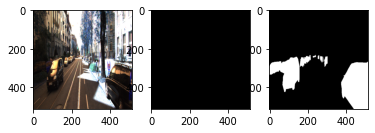

In [ ]:
from google.colab.patches import cv2_imshow
result = model.predict(np.expand_dims(testing,axis=0))[0]

print(result)

print(result.shape)
result = result * 255
_,plot = pyplt.subplots(1,3)
plot[0].imshow(testing)
plot[1].imshow(cv2.cvtColor(result[:,:,0],cv2.COLOR_BGR2RGB))
plot[2].imshow(cv2.cvtColor(valid,cv2.COLOR_BGR2RGB))

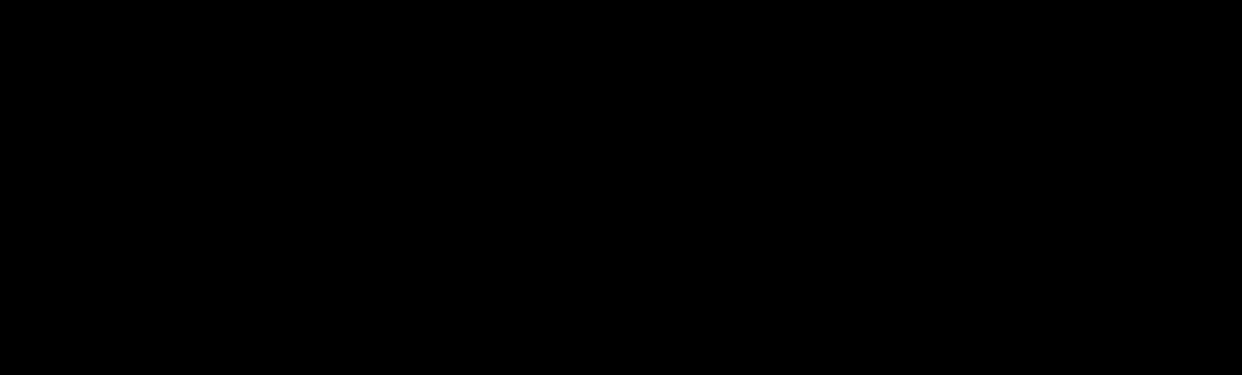

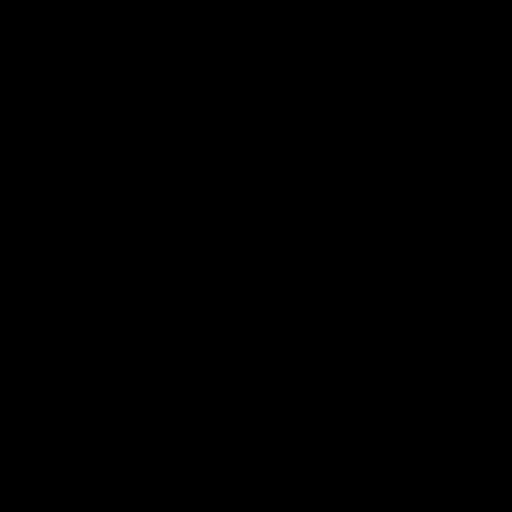

In [ ]:
from google.colab.patches import cv2_imshow
image = cv2.imread("/content/3D-Shape-Completion-For-Autonomous-Vehicles/Assignments/data_semantics/new_train_mask/000042_10.png",cv2.IMREAD_GRAYSCALE)

cv2_imshow(image)
image = cv2.resize(image,(512,512))
for i in range(len(image[:,0])):
    for j in range(len(image[0,:])):
        if(image[i,j]==26):
            image[i,j] = 255
        else:
            image[i,j]=0
cv2_imshow(image)
